In [1]:
import corner
import numpy as np
import json
import matplotlib.pyplot as plt

# Frequentist
import pyhf
pyhf.set_backend('jax')

# Bayesian
import pymc
import arviz

%load_ext autoreload
%autoreload 

In [2]:
from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

In [ ]:
# from os.path import dirname, realpath, sep, pardir
# import sys
# sys.path.append('/Users/malinhorstmann/Library/Mobile Documents/com~apple~CloudDocs/Documents/Bayesian_pyhf/Documenation/PyHEP23/PyHEP23/src')

# from Bayesian_pyhf import infer

# Example 1: Adapted Public Likelihood
- Search for displaced leptons in $\sqrt s$ = 13 TeV $pp$ collisions with the ATLAS detector
- https://www.hepdata.net/record/resource/1981552?landing_page=true

In [3]:
with open('workspaces/SRee_SRmm_Srem.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model=model, include_auxdata=False)
observations_inclAux = workspace.data(model=model, include_auxdata=True)

/Users/malinhorstmann/Library/Mobile Documents/com~apple~CloudDocs/Documents/Bayesian_pyhf/Documenation/PyHEP23/PyHEP23/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
print(f'observations: {observations}')

observations: [9.99999993922529e-09, 9.99999993922529e-09, 9.99999993922529e-09]


### Bayesian evaluation:

  $ p(\theta \vert x) \approx p(x \vert \theta)  p(\theta)$

In [5]:
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'HalfNormal_Unconstrained', 'sigma': [3.]}
}

In [6]:
nDraws = 1000
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_data = pymc.sample(nDraws, chains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [7]:
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_pred = pymc.sample_posterior_predictive(post_data)

Sampling: [Expected_Data]


In [8]:
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    prior_pred = pymc.sample_prior_predictive(nDraws)

Sampling: [Expected_Data, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


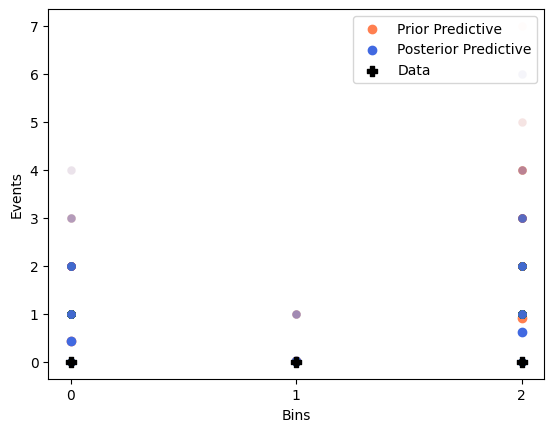

In [9]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred)

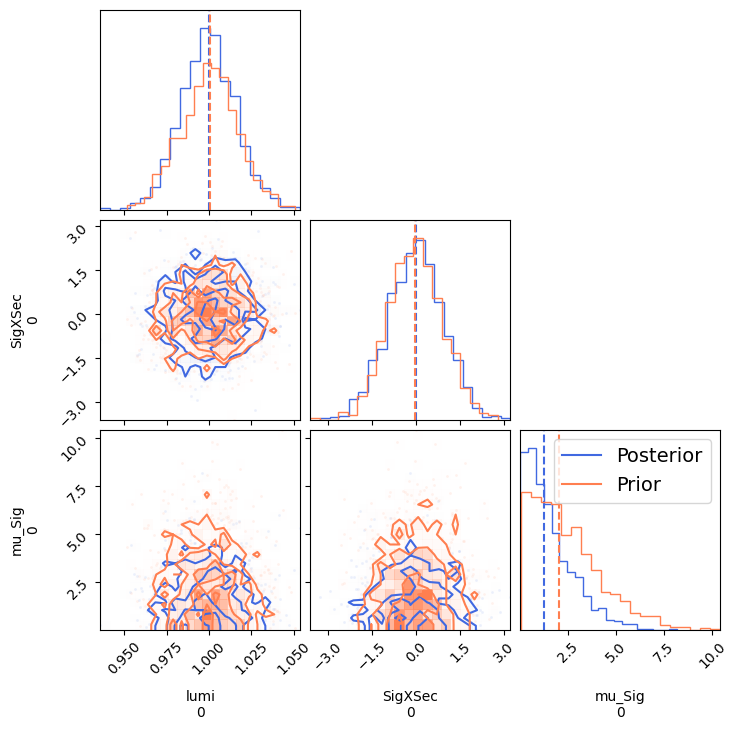

In [10]:
a = corner.corner(post_data.posterior, var_names=['lumi', 'SigXSec', 'mu_Sig'], quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=['lumi', 'SigXSec', 'mu_Sig'], quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)

# Example 2: Toy $\gamma \gamma$ to Higgs

Bayesian evaluation:

In [11]:
with open('workspaces/GammaGammaHiggs.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model=model, include_auxdata=False)
observations_inclAux = workspace.data(model=model, include_auxdata=True)

In [12]:
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [5.]}
}

In [13]:
nDraws = 1000
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_data = pymc.sample(nDraws, chains = 1)
    post_pred = pymc.sample_posterior_predictive(post_data)
    prior_pred = pymc.sample_prior_predictive(nDraws)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, NormUncertainty]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, NormUncertainty, mu]


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'NormUncertainty'}>,
        <Axes: title={'center': 'NormUncertainty'}>]], dtype=object)

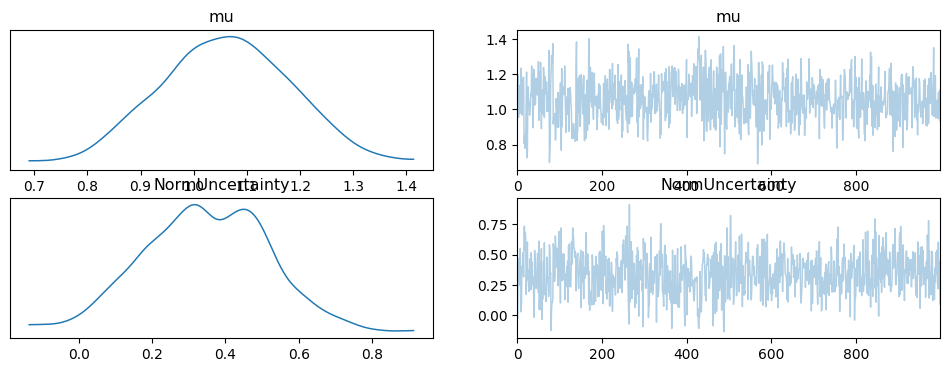

In [14]:
arviz.plot_trace(post_data, var_names=model.config.par_names)

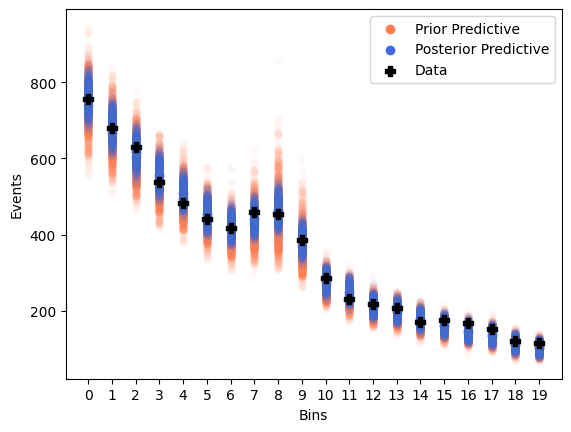

In [15]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred)

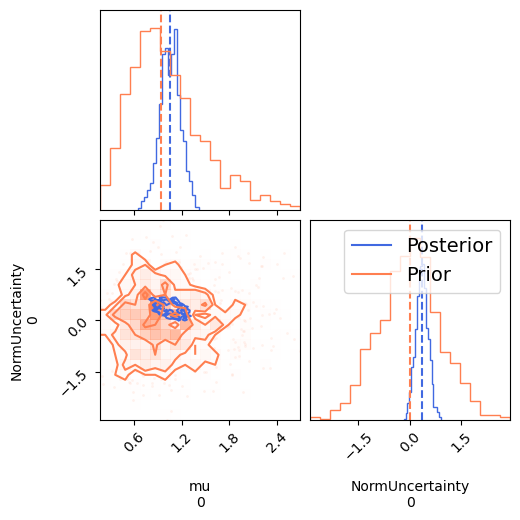

In [9]:
a = corner.corner(post_data.posterior, var_names=model.config.par_names, quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=model.config.par_names, quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)

In [16]:
print(f'Posterior mean for mu: {np.array(post_data.posterior.mu[0]).mean()}')

Posterior mean for mu: 1.0607336719547493


Frequentist evaluation:

In [17]:
print(f'MLE best fit value for mu: {pyhf.infer.mle.fit(pdf=model, data=observations_inclAux)[model.config.poi_index]}')

MLE best fit value for mu: 1.0755664000067255


In [18]:
!pip freeze

anyio==4.0.0
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
arviz==0.16.1
asttokens==2.4.0
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.0
backcall==0.2.0
-e git+https://github.com/malin-horstmann/PyHEP23.git@6d2a9ccd6da3df4108f1464fb8c9df57b35f1ddd#egg=Bayesian_pyhf
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==5.3.1
certifi==2023.7.22
cffi==1.16.0
charset-normalizer==3.3.0
click==8.1.7
cloudpickle==2.2.1
comm==0.1.4
cons==0.4.6
contourpy==1.1.1
corner==2.2.1
cycler==0.12.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
etuples==0.3.9
exceptiongroup==1.1.3
executing==2.0.0
fastjsonschema==2.18.1
fastprogress==1.0.3
filelock==3.12.4
fonttools==4.43.1
fqdn==1.5.1
h5netcdf==1.2.0
h5py==3.9.0
idna==3.4
importlib-metadata==6.8.0
importlib-resources==6.1.0
ipykernel==6.25.2
ipython==8.16.1
isoduration==20.11.0
jax==0.4.2
jaxlib==0.4.2
jedi==0.19.1
Jinja2==3.1.2
json5==0.9.14
jsonpatch==1.33
jsonpointer==2.4
jsonschema==4.19.1
jsonschema-specifications==2023.